In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("algerian_fire_cleaned.csv")
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


In [2]:
df.shape

(243, 15)

# Correlation

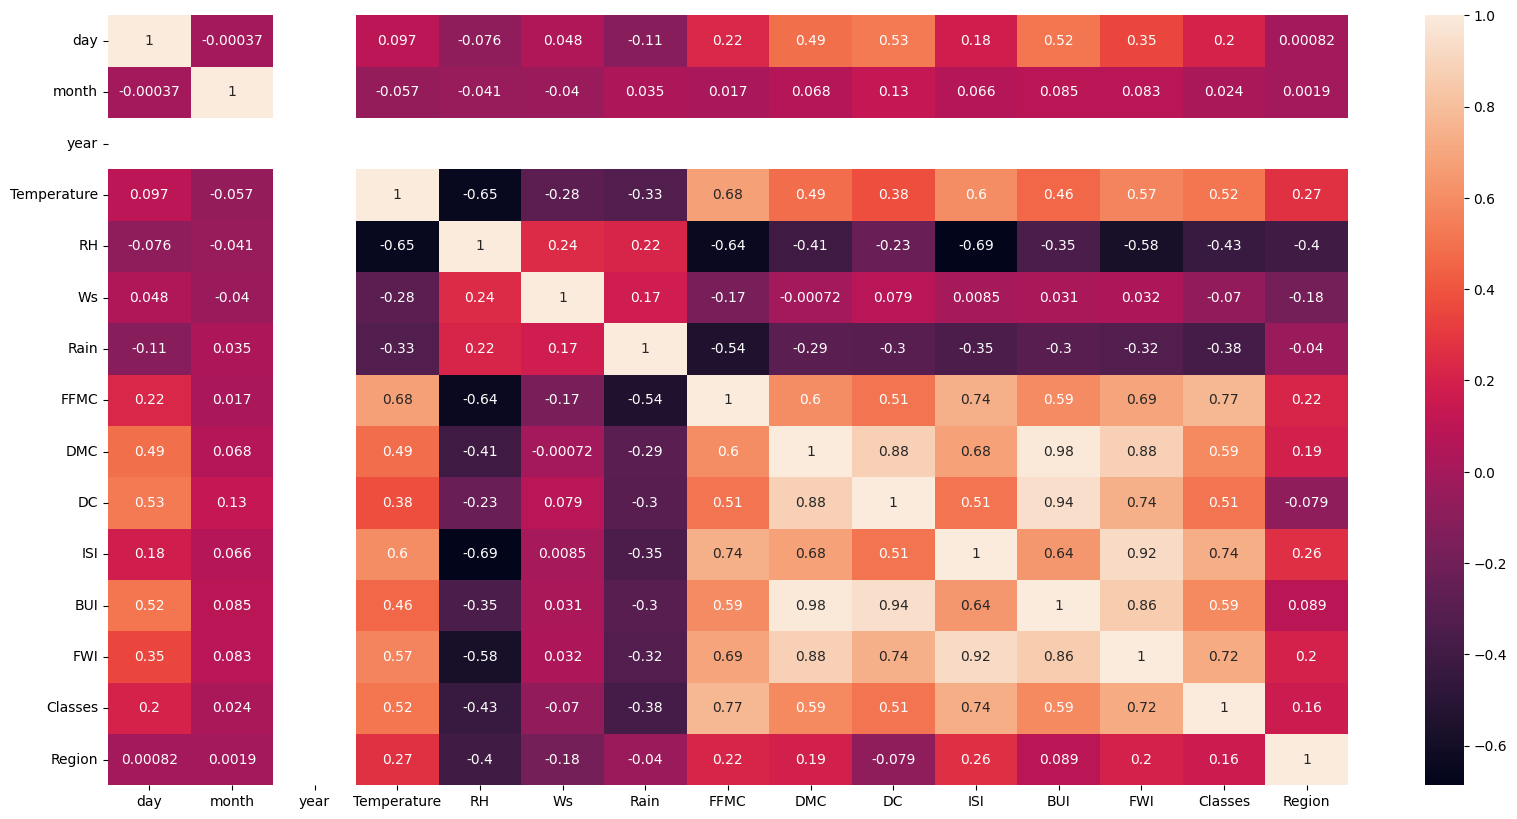

In [3]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot

In [5]:
num_data = df[['RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI']]
cat_data = df[["month","Classes", "Region"]]
y = df["Temperature"]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(num_data, y, test_size=0.33)

# Feature selection

In [6]:
def select_numericals_mutual(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k = k )
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

## View best features

Feature RH: 0.235130
Feature Ws: 0.127729
Feature Rain: 0.117680
Feature FFMC: 0.411890
Feature DMC: 0.250628
Feature DC: 0.142347
Feature ISI: 0.366430


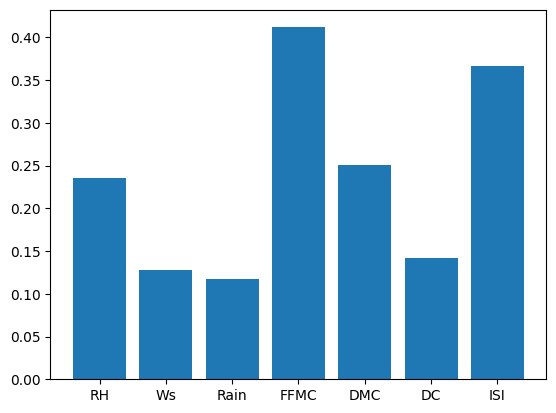

In [7]:
# feature selection
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, "all")

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
    
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.xticks(range(len(fs.scores_)), fs.feature_names_in_)
pyplot.show()

## view best number of features

>3 -2.187626 (0.380445)
>4 -2.053747 (0.404488)
>5 -2.068226 (0.405363)
>6 -2.081618 (0.405816)
>7 -2.084320 (0.430081)


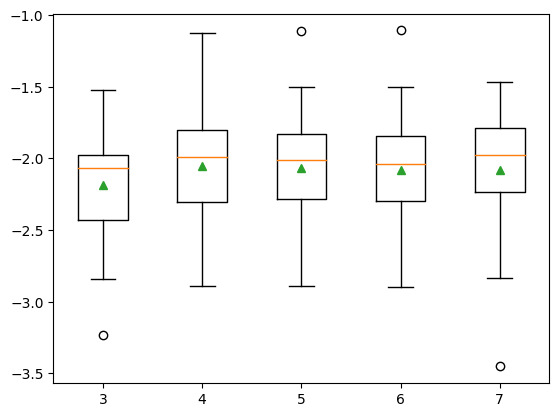

In [8]:
# define number of features to evaluate
num_features = [3,4,5,6,7]
# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LinearRegression()
    X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train_fs, y_train, scoring='neg_mean_absolute_error', cv=cv,n_jobs=-1)
    results.append(scores)
    # summarize the results
    print('>%d %f (%f)' % (k, np.mean(scores), np.std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

# feature scaling

In [9]:
def scaling(X_train, X_test):
    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)    
    return X_train_scaled, X_test_scaled

# Model training

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Linear regression

In [38]:
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k = 7)

linreg=LinearRegression()

#feature scaling
X_train_scaled, X_test_scaled = scaling( X_train_fs, X_test_fs )

# model training with cross-validation
scores_mae = -1 * cross_val_score(linreg, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(linreg, X_train_scaled, y_train, cv=5, scoring='r2')

# mean scores
mean_mae = scores_mae.mean()
mean_r2 = scores_r2.mean()

print("Mean cross-validation MAE:", mean_mae)
print("Mean cross-validation R2 score:", mean_r2)

Mean cross-validation MAE: 2.1066754828609926
Mean cross-validation R2 score: 0.4587121350655929


# Lasso

In [39]:
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k = 7)
#model
lasso=Lasso()

#feature scaling
X_train_scaled, X_test_scaled = scaling( X_train_fs, X_test_fs )

# model training with cross-validation
scores_mae = -1 * cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='r2')

# mean scores
mean_mae = scores_mae.mean()
mean_r2 = scores_r2.mean()

print("Mean cross-validation MAE:", mean_mae)
print("Mean cross-validation R2 score:", mean_r2)

Mean cross-validation MAE: 2.309256888796958
Mean cross-validation R2 score: 0.36028931666687475


# Ridge

In [40]:
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k = 7)
ridge=Ridge()

#feature scaling
X_train_scaled, X_test_scaled = scaling( X_train_fs, X_test_fs )

# model training with cross-validation
scores_mae = -1 * cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2')

# mean scores
mean_mae = scores_mae.mean()
mean_r2 = scores_r2.mean()

print("Mean cross-validation MAE:", mean_mae)
print("Mean cross-validation R2 score:", mean_r2)

Mean cross-validation MAE: 2.1021259028829746
Mean cross-validation R2 score: 0.4609494722501176


# Elastic Net

In [41]:
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k = 7)
#model
elastic=ElasticNet()

#feature scaling
X_train_scaled, X_test_scaled = scaling( X_train_fs, X_test_fs )

# model training with cross-validation
scores_mae = -1 * cross_val_score(elastic, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(elastic, X_train_scaled, y_train, cv=5, scoring='r2')

# mean scores
mean_mae = scores_mae.mean()
mean_r2 = scores_r2.mean()

print("Mean cross-validation MAE:", mean_mae)
print("Mean cross-validation R2 score:", mean_r2)

Mean cross-validation MAE: 2.185507208079522
Mean cross-validation R2 score: 0.4233219904947714


# Hyper parameter

In [44]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

In [45]:
# feature selection
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k=7)

# feature scaling
X_train_scaled, X_test_scaled = scaling(X_train_fs, X_test_fs)

# define the Ridge regressor
ridge = Ridge()

# define the hyperparameters to search over
params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# perform grid search with cross-validation
grid_search = GridSearchCV(ridge, params, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)

# print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", -1 * grid_search.best_score_)

Best hyperparameters: {'alpha': 10}
Best cross-validation score: 2.077857410308553


### with best parameter

In [48]:
# feature selection
X_train_fs, X_test_fs, fs = select_numericals_mutual(X_train, y_train, X_test, k=7)

# feature scaling
X_train_scaled, X_test_scaled = scaling(X_train_fs, X_test_fs)

# define the Ridge regressor with the best hyperparameters
ridge = Ridge(alpha=grid_search.best_params_['alpha'])

# train the model on the entire training set
ridge.fit(X_train_scaled, y_train)

# make predictions on the test set
y_pred = ridge.predict(X_test_scaled)

# calculate R2 score and adjusted R2 score
r2score = r2_score(y_test, y_pred)
adj_r2score = 1 - (1 - r2score) * (len(y_test) - 1) / (len(y_test) - X_test_scaled.shape[1] - 1)

print("R2 Score:", r2score)
print("Adjusted R2 Score:", adj_r2score)

R2 Score: 0.5864099686637827
Adjusted R2 Score: 0.5467506505904468
